# Overfitting the model

This notebook trains a single agent over all possible combinations of input lists of size 3. 

The goal is for the agent to give its input back directly. This ensures that the model is able to learn something, and is also useful to appraise the model convergence speed.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from actor_critic_handler import ActorCriticHandler
from environment import Environment, are_equal_reward, translate

sns.set_theme(style="darkgrid")
sns.set_palette("hls")


def collect_data(episode, encoder_value, log_prob, reward, actor_loss, critic_loss, tderr):
    return [{'episode': episode,
             'batch': batch,
             'encoder_value': ve,
             'log_prob': lg,
             'actor_loss': al,
             'critic_loss': cl,
             'tderr': td,
             'reward': r} for batch, (ve, lg, r, al, cl, td) in enumerate(zip(encoder_value,
                                                                              log_prob,
                                                                              reward,
                                                                              actor_loss,
                                                                              critic_loss,
                                                                              tderr))]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

num_items = 2
num_chars = 2
list_max_len = 3
sentence_max_len = 3

global_list = []

env = Environment(input_max_len=list_max_len)

encoder_params = {"src_size": num_items,
                  "tgt_size": num_items,
                  "src_max_len": list_max_len,
                  "tgt_max_len": list_max_len,
                  "lr": 5e-5,
                  "lbd": 0.4,
                  "epsilon": 0.5,
                  "capacity": 28,
                  "balance": 0.8,
                  "value_iter": 1,
                  "num_twins": 2,
                  "threshold": 0.3,
                  "dropout": 0.01}
encoder = ActorCriticHandler(device, **encoder_params)


comb = [[1, 0, 0],
        [1, 1, 0],
        [1, 1, 1],
        [1, 1, 2],
        [1, 2, 0],
        [1, 2, 1],
        [1, 2, 2],
        [2, 0, 0],
        [2, 1, 0],
        [2, 1, 1],
        [2, 1, 2],
        [2, 2, 0],
        [2, 2, 1],
        [2, 2, 2]]

encoder_input = torch.Tensor(comb).long().t().to(device)

encoder.to(device)

visualization_rate = 50
for episode in range(10):

    # ========== Intermediate Loops ==========
    # encoder_input = env.get_input_batch(num_items=2, bsz=5)

    # The Encoder generates the sentence.
    encoder_last_action = encoder.intermediate_train_loop(
        encoder_input, adapt_epsilon=False)

    encoder_output = encoder.actions

    # ========== Final Step ===========

    reward = are_equal_reward(encoder_input, encoder_output)

    # --> Encoder last step
    encoder_values = torch.cat([encoder.get_state_value(
        encoder_input, masked=False) for _ in range(5)], dim=0)
    _, indices = torch.min((encoder_values-1)**2, dim=0)
    encoder_value = encoder_values[indices, range(14)]

    log_prob = encoder.get_log_prob(encoder_input, encoder_last_action)

    # --> TD error, next_value == 0
    tderr = reward - encoder_value

    critic_loss = -tderr.detach()*encoder_value
    actor_loss = -tderr.detach()*log_prob

    encoder.optim_step(critic_loss, actor_loss, masked=False)

    # ====== Saving successful episodes into memory =======

    encoder.push_to_memory(encoder_input, reward, encoder_value)

    # ====== Resetting agent inner state =====

    encoder.reset_state()

    # ======= Collecting data for data visualization ========

    global_list += collect_data(episode,
                                encoder_value.squeeze(0).tolist(),
                                (encoder.log_probs.sum(
                                    dim=0)/(encoder.actions != 0).sum(dim=0)).squeeze(0).tolist(),
                                (reward).squeeze(0).tolist(),
                                actor_loss.squeeze(0).tolist(),
                                critic_loss.squeeze(0).tolist(),
                                tderr.squeeze(0).tolist())
    # ===== Playing memory =======
    encoder.replay_memory(20, agent_type='decoder')

    if (episode+1) % visualization_rate == 0:
        print("Episode: ", episode)
        print("Ménestrel encode: \n", encoder_input)
        print("en: \n", encoder_output)
        print("or translated: \n", translate(encoder_output))
        print("and we have {} /14 success !".format(are_equal_reward(encoder_input,
                                                                     encoder_output, 
                                                                     penalize=False).sum()))
        if episode+1 == visualization_rate:
            df = pd.DataFrame(global_list)
        else:
            df = df.append(global_list)
            df = df.reset_index(drop=True)
        df = df.astype({"batch": 'category'})
        global_list = []
        df = df.drop(columns=['cumsum', 'average_actor_loss',
                              'average_encoder_value', 'average_log_prob'], errors='ignore')
        df['cumsum'] = df.groupby('batch').reward.cumsum()
        df['cumsum'] = df['cumsum'] / (df['episode']+1)
        def f(x): return x.rolling(window=50).mean()
        df['average_actor_loss'] = df.groupby('batch').actor_loss.apply(f)
        df['average_encoder_value'] = df.groupby(
            'batch').encoder_value.apply(f)
        df['average_log_prob'] = df.groupby(
            'batch').log_prob.apply(f)
        sns.relplot(x="episode", y="average_encoder_value", hue="batch",
                    kind="line", linewidth=2, ci=None,  data=df)
        sns.relplot(x="episode", y="average_log_prob", hue="batch",
                    kind="line", linewidth=2, ci=None,  data=df)
        sns.relplot(x="episode", y="cumsum", hue="batch", kind="line",
                    linewidth=2, ci=None,  data=df)
        plt.show()


cpu


To interpret the curves:

- The value should converge to 1 for each batch list, because the agent is able to give its input back. 
- The reward here is the ratio of good rewards over episodes. It should converge to 1. Whenever the curve looks like 1/x, it means that the agent produces the same good list. 

In [2]:
encoder.reset_state()
for _ in range(sentence_max_len):
    with torch.no_grad():
        encoder(encoder_input)
        encoder.update_state()
print("Ménestrel encode: \n", encoder_input)
print("en: \n", encoder.actions)
print("or translated: \n", translate(encoder.actions))
print("and we have {} /14 success !".format(are_equal_reward(encoder_input, encoder.actions, penalize=False).sum()))

Ménestrel encode: 
 tensor([[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2],
        [0, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2],
        [0, 0, 1, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2]])
en: 
 tensor([[2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
or translated: 
 ['b', 'b', 'b', 'b', 'a', 'b', 'a', 'a', 'b', 'a', 'a', 'a', 'b', 'a']
and we have 0 /14 success !


The agent is able to overfit on this batch, meaning that it is possible to learn through this task and reward function.

cpu
Episode:  124
Ménestrel encode: 
 tensor([[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2],
        [0, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2],
        [0, 0, 1, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2]])
en: 
 tensor([[1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2],
        [0, 0, 1, 2, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])
or translated: 
 ['a', 'a', 'ba', 'ab', 'bb', 'b', 'b', 'b', 'aba', 'aa', 'bb', 'b', 'a', 'b']
and we have 2 /14 success !
tensor([[-1.1224, -1.1856, -1.1704, -1.3157, -1.0667, -1.2394, -1.2125, -0.7417,
         -1.2769, -1.4264, -1.0389, -0.9386, -1.3859, -0.9179],
        [-1.0272, -1.1586, -1.1069, -1.3695, -1.0913, -1.3819, -1.2894, -0.6982,
         -1.2120, -1.3581, -1.0051, -0.7555, -1.5855, -0.8304],
        [-1.0098, -1.2652, -1.0804, -1.2522, -1.0832, -1.4207, -1.1180, -0.7265,
         -1.0635, -1.4334, -1.2556, -0.8107, -1.4261, -0.8582],
        [-1.1296, -1.0535, -1.1137, -1.3112, -1.0137, -1.2636, -1.2033, -0.6567,
   

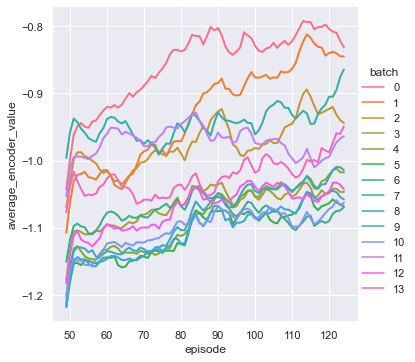

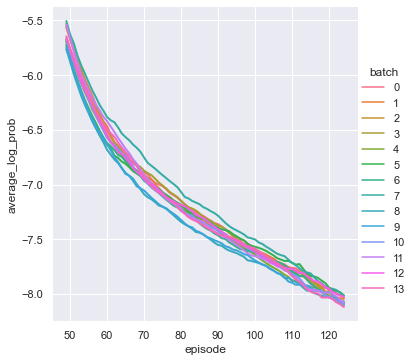

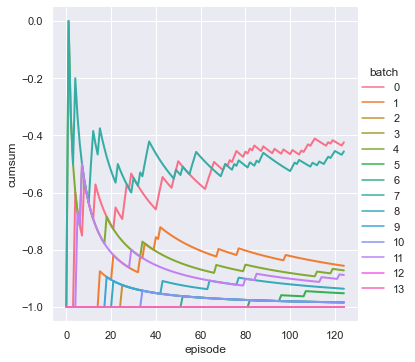

         27722536 function calls (27233990 primitive calls) in 332.082 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      663    0.001    0.000    0.014    0.000 <__array_function__ internals>:2(all)
    14050    0.017    0.000    0.258    0.000 <__array_function__ internals>:2(amax)
    14002    0.018    0.000    0.271    0.000 <__array_function__ internals>:2(amin)
      903    0.002    0.000    0.026    0.000 <__array_function__ internals>:2(any)
        8    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(append)
     2808    0.004    0.000    0.057    0.000 <__array_function__ internals>:2(around)
       71    0.000    0.000    0.003    0.000 <__array_function__ internals>:2(array_equal)
      222    0.000    0.000    0.004    0.000 <__array_function__ internals>:2(atleast_1d)
       11    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
       11    0.000    0.000    0

KeyboardInterrupt: 

In [4]:
import cProfile
import main

cProfile.run('main.run()')


In [1]:
0.8*10

8.0

In [5]:
round(0.86*10)

9